<h2 style="text-align:center;font-weight:bold;font-size:24px;">Análisis de Noticias Financieras con NLP y Deep Learning: Predicción Bursátil y Detección de Información Falsa</h2>

<h2 style="text-align:center;font-weight:bold;font-size:24px;">Camilo A. Lyons Valero</h2>

**____________________________________________________________________________________________________________________________**

En los mercados financieros, las noticias impactan directamente en los precios de los activos y en la toma de decisiones de los inversionistas. Sin embargo, la gran cantidad de información disponible, junto con la proliferación de noticias falsas o engañosas, hace necesario el uso de técnicas avanzadas de Procesamiento de Lenguaje Natural (NLP) y Deep Learning para:

- Analizar el sentimiento en noticias financieras.

- Predecir movimientos bursátiles basados en el contenido textual.

- Detectar posibles noticias falsas que puedan manipular el mercado.

Este trabajo explora cómo modelos de redes neuronales y NLP pueden optimizar estas tareas, proporcionando herramientas para una inversión más informada y segura.

<h3 style="text-align:center;font-weight:bold;">IMPORTACIÓN DE LIBRERÍAS E INSTALACIONES NECESARIAS</h3>

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacy-lookups-data
!pip install scikit-learn textblob pandas numpy matplotlib seaborn


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 320.0 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.8 MB 544.7 kB/s eta 0:00:24
      --------------------------------------- 0.3/12.8 MB 2.0 MB/s eta 0:00:07
     -- ------------------------------------- 0.9/12.8 MB 5.1 MB/s eta 0:00:03
     --------- ------------------------------ 3.1/12.8 MB 14.2 MB/s eta 0:00:01
     ----------------- ---------------------- 5.6/12.8 MB 21.1 MB/s eta 0:00:01
     -------------------- ------------------- 6.5/12.8 MB 20.6 MB/s eta 0:00:01
     --------------------------- ------------ 8.8/12.8 MB 24.5 MB/s eta 0:00:01
     --------------------------------- ----- 10.9/12.8 MB 43.5 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 43.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 36.4 MB/s eta 0:00:00
[+] Download and installation successful
You can n

In [2]:
import pandas as pd
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.util import minibatch
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from spacy.training import Example

In [3]:
ruta_del_archivo = "https://raw.githubusercontent.com/clyonsv/Data-Science-3-Camilo-Lyons/main/Sentiment_Stock_data.csv"
df = pd.read_csv(ruta_del_archivo, sep=",")

#### Exploración inicial

In [4]:
print("📊 Primeras filas del dataset:")
print(df.head())

print("\n📋 Información del dataset:")
print(df.info())

print("\n🔍 Distribución de sentimientos:")
print(df['Sentiment'].value_counts(normalize=True))

📊 Primeras filas del dataset:
   Unnamed: 0  Sentiment                                           Sentence
0           0          0  According to Gran , the company has no plans t...
1           1          1  For the last quarter of 2010 , Componenta 's n...
2           2          1  In the third quarter of 2010 , net sales incre...
3           3          1  Operating profit rose to EUR 13.1 mn from EUR ...
4           4          1  Operating profit totalled EUR 21.1 mn , up fro...

📋 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108751 entries, 0 to 108750
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  108751 non-null  int64 
 1   Sentiment   108751 non-null  int64 
 2   Sentence    108750 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB
None

🔍 Distribución de sentimientos:
Sentiment
1    0.512409
0    0.487591
Name: proportion, dtype: float64


Teniendo en cuenta lo anterior, el dataset en su forma inicial presenta unas buenas condiciones, donde la gran mayoria de datos no estan nulos o vacios, presentan un tipo de dato acorde, y ademas, su variable categorica principal (sentiment) se encuentra balanceada.

<h3 style="text-align:center;font-weight:bold;">NLP Y PREPROCESAMIENTO</h3>

#### Regex - Tokenización

In [5]:
nlp = spacy.load("en_core_web_sm")

def limpiar_texto(texto):
    texto = texto.lower()  # Minúsculas
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)  # Eliminar URLs
    texto = re.sub(r"[^\w\s]", '', texto)  # Eliminar caracteres especiales
    texto = re.sub(r"\d+", '', texto)  # Eliminar números
    texto = re.sub(r"\s+", ' ', texto).strip()  # Eliminar espacios múltiples
    return texto

df['cleaned_text'] = df['Sentence'].astype(str).apply(limpiar_texto)

# Tokenización y eliminación de stopwords
def tokenizar_y_remover_stopwords(texto):
    doc = nlp(texto)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

df['tokens_text'] = df['cleaned_text'].apply(tokenizar_y_remover_stopwords)

print("\n✅ Texto limpio y tokenizado:")
print(df[['Sentence', 'cleaned_text', 'tokens_text']].head())


✅ Texto limpio y tokenizado:
                                            Sentence  \
0  According to Gran , the company has no plans t...   
1  For the last quarter of 2010 , Componenta 's n...   
2  In the third quarter of 2010 , net sales incre...   
3  Operating profit rose to EUR 13.1 mn from EUR ...   
4  Operating profit totalled EUR 21.1 mn , up fro...   

                                        cleaned_text  \
0  according to gran the company has no plans to ...   
1  for the last quarter of componenta s net sales...   
2  in the third quarter of net sales increased by...   
3  operating profit rose to eur mn from eur mn in...   
4  operating profit totalled eur mn up from eur m...   

                                         tokens_text  
0  according gran company plans production russia...  
1  quarter componenta s net sales doubled eurm eu...  
2  quarter net sales increased eur mn operating p...  
3  operating profit rose eur mn eur mn correspond...  
4  operating profit t

#### Lematización y análisis gramatical con spaCy

In [6]:
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(lemas)

df['lemmas_text'] = df['cleaned_text'].apply(lematizar_texto)

# Análisis gramatical (POS tagging y NER)
def analizar_gramatica(texto):
    doc = nlp(texto)
    pos_tags = [token.pos_ for token in doc]
    entidades = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entidades

df['pos_tags'], df['entities'] = zip(*df['cleaned_text'].apply(analizar_gramatica))

print("\n📌 POS tags y entidades nombradas:")
print(df[['cleaned_text', 'pos_tags', 'entities']].head())


📌 POS tags y entidades nombradas:
                                        cleaned_text  \
0  according to gran the company has no plans to ...   
1  for the last quarter of componenta s net sales...   
2  in the third quarter of net sales increased by...   
3  operating profit rose to eur mn from eur mn in...   
4  operating profit totalled eur mn up from eur m...   

                                            pos_tags  \
0  [VERB, ADP, VERB, DET, NOUN, VERB, DET, NOUN, ...   
1  [ADP, DET, ADJ, NOUN, ADP, PROPN, PART, ADJ, N...   
2  [ADP, DET, ADJ, NOUN, ADP, ADJ, NOUN, VERB, AD...   
3  [NOUN, NOUN, VERB, ADP, PROPN, PROPN, ADP, PRO...   
4  [NOUN, NOUN, VERB, PROPN, PROPN, ADV, ADP, PRO...   

                                            entities  
0                                    [(russia, GPE)]  
1  [(the last quarter, DATE), (the same period a ...  
2                        [(the third quarter, DATE)]  
3                                                 []  
4               

#### Extracción de características

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['lemmas_text'])

# Frecuencia de palabras
palabras_frecuentes = Counter(" ".join(df['lemmas_text']).split()).most_common(10)
print("\n🔍 Palabras más frecuentes:")
print(palabras_frecuentes)

# Frecuencia de entidades nombradas
entidades_frecuentes = Counter([ent[1] for sublist in df['entities'] for ent in sublist]).most_common(5)
print("\n🏷️ Entidades nombradas más frecuentes:")
print(entidades_frecuentes)


🔍 Palabras más frecuentes:
[('say', 5475), ('new', 4002), ('year', 3552), ('world', 3086), ('kill', 2655), ('s', 2423), ('government', 2376), ('eur', 2273), ('police', 2206), ('people', 2141)]

🏷️ Entidades nombradas más frecuentes:
[('GPE', 34463), ('NORP', 22253), ('PERSON', 18742), ('ORG', 16499), ('DATE', 11181)]


<h3 style="text-align:center;font-weight:bold;">ANALISIS DE SENTIMIENTO CON SPACY</h3>

In [8]:
nlp = spacy.load("en_core_web_sm")

if "attribute_ruler" in nlp.pipe_names:
    nlp.remove_pipe("attribute_ruler")

if "tagger" not in nlp.pipe_names:
    nlp.add_pipe("tagger")

if "lemmatizer" in nlp.pipe_names:
    nlp.remove_pipe("lemmatizer")

muestra_df = df.sample(frac=0.8, random_state=42)

train_df, test_df = train_test_split(muestra_df, test_size=0.2, random_state=42)

train_data = []
for text, label in zip(train_df['lemmas_text'], train_df['Sentiment']):
    doc = nlp.make_doc(text)
    cats = {"POSITIVE": label == 1, "NEGATIVE": label == 0}
    example = Example.from_dict(doc, {"cats": cats})
    train_data.append(example)

config = {
    "model": {
        "@architectures": "spacy.TextCatCNN.v1",
        "tok2vec": {  
            "@architectures": "spacy.Tok2Vec.v2",
            "embed": {
                "@architectures": "spacy.MultiHashEmbed.v2",
                "width": 64,
                "rows": [2000, 2000, 2000, 2000],  
                "attrs": ["NORM", "PREFIX", "SUFFIX", "SHAPE"],
                "include_static_vectors": False,
            },
            "encode": {
                "@architectures": "spacy.MaxoutWindowEncoder.v2",
                "width": 64,
                "window_size": 1,
                "maxout_pieces": 3,
                "depth": 2,
            },
        },
        "exclusive_classes": True,
    }
}

if "textcat" not in nlp.pipe_names:
    textcat = nlp.add_pipe("textcat", config=config, last=True)
else:
    textcat = nlp.get_pipe("textcat")

textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

optimizer = nlp.initialize()
for epoch in range(3):  
    random.shuffle(train_data)
    losses = {}
    for batch in minibatch(train_data, size=128):  
        nlp.update(batch, sgd=optimizer, losses=losses)
    print(f"Época {epoch + 1}, Pérdida: {losses['textcat']:.4f}")

def predecir_sentimiento_spacy(texto):
    doc = nlp(texto)
    return 1 if doc.cats["POSITIVE"] > doc.cats["NEGATIVE"] else 0

train_df['sentimiento_spacy'] = train_df['lemmas_text'].apply(predecir_sentimiento_spacy)
accuracy_train = accuracy_score(train_df['Sentiment'], train_df['sentimiento_spacy'])
print(f"📘 Accuracy en entrenamiento: {accuracy_train:.2%}")

test_df['sentimiento_spacy'] = test_df['lemmas_text'].apply(predecir_sentimiento_spacy)
accuracy_test = accuracy_score(test_df['Sentiment'], test_df['sentimiento_spacy'])
print(f"📗 Accuracy en prueba: {accuracy_test:.2%}")

print("\n📋 Reporte de clasificación en prueba:\n")
print(classification_report(test_df['Sentiment'], test_df['sentimiento_spacy']))

Época 1, Pérdida: 135.7901
Época 2, Pérdida: 130.3536
Época 3, Pérdida: 116.1066
📘 Accuracy en entrenamiento: 77.13%
📗 Accuracy en prueba: 52.72%

📋 Reporte de clasificación en prueba:

              precision    recall  f1-score   support

           0       0.52      0.47      0.49      8517
           1       0.53      0.58      0.56      8884

    accuracy                           0.53     17401
   macro avg       0.53      0.53      0.53     17401
weighted avg       0.53      0.53      0.53     17401



### Análisis de resultados

Se desarrolló un clasificador de sentimientos utilizando spaCy para predecir si una noticia bursátil es positiva (las acciones subirán) o negativa/neutral (las acciones bajarán). El proceso incluyó la limpieza y preprocesamiento del texto (tokenización, eliminación de stopwords y lematización). Durante el entrenamiento, se observó que el modelo presentaba un sobreajuste, con una precisión en entrenamiento del 76.34% y una precisión en prueba del 52.20%. Esto sugiere que el modelo aprendió patrones específicos de los datos de entrenamiento pero no generalizó bien a datos nuevos.

Se realizaron varias modificaciones para mejorar el rendimiento, como ajustar el tamaño del lote, verificar que el dataset se encontrara balanceado, reducir el número de épocas y agregar regularización. Sin embargo, estas mejoras no lograron cerrar la brecha entre el rendimiento en entrenamiento y prueba. Los posibles motivos incluyen la complejidad del lenguaje en las noticias financieras, la falta de embeddings preentrenados específicos del dominio, o la necesidad de un modelo más avanzado. Como mejora futura, se recomienda explorar el uso de embeddings preentrenados y modelos basados en transformers para capturar mejor el significado semántico del texto.

<h3 style="text-align:center;font-weight:bold;">ANALISIS DE SENTIMIENTO CON TEXTBLOB</h3>

In [9]:
def clasificar_sentimiento_textblob(texto, umbral_positivo=0.1, umbral_negativo=-0.1):
    blob = TextBlob(texto)
    polaridad = blob.sentiment.polarity
    if polaridad > umbral_positivo:
        return 1  # Positivo
    elif polaridad < umbral_negativo:
        return 0  # Negativo
    else:
        return 0  # Neutral (mapeado a negativo)

df['sentimiento_textblob'] = df['lemmas_text'].apply(clasificar_sentimiento_textblob)

accuracy_textblob = accuracy_score(df['Sentiment'], df['sentimiento_textblob'])
print(f"📦 Accuracy de TextBlob (umbral ajustado): {accuracy_textblob:.2%}")

# Reporte de clasificación
print("\n📋 Reporte de clasificación de TextBlob (umbral ajustado):\n")
print(classification_report(df['Sentiment'], df['sentimiento_textblob']))

📦 Accuracy de TextBlob (umbral ajustado): 49.49%

📋 Reporte de clasificación de TextBlob (umbral ajustado):

              precision    recall  f1-score   support

           0       0.49      0.85      0.62     53026
           1       0.52      0.15      0.24     55725

    accuracy                           0.49    108751
   macro avg       0.51      0.50      0.43    108751
weighted avg       0.51      0.49      0.43    108751



### Polaridad de 10 registros aleatorios

In [10]:
def clasificar_sentimiento_textblob(texto, umbral_positivo=0.1, umbral_negativo=-0.1):
    blob = TextBlob(texto)
    polaridad = blob.sentiment.polarity
    if polaridad > umbral_positivo:
        return 1, polaridad  # Positivo
    elif polaridad < umbral_negativo:
        return 0, polaridad  # Negativo
    else:
        return 0, polaridad  # Neutral (mapeado a negativo)

df[['sentimiento_textblob', 'polaridad_textblob']] = df['lemmas_text'].apply(
    lambda x: pd.Series(clasificar_sentimiento_textblob(x))
)

muestra_aleatoria = df.sample(10, random_state=42)[['lemmas_text', 'Sentiment', 'sentimiento_textblob', 'polaridad_textblob']]

print("📊 Muestra aleatoria de registros con polaridad y predicción de TextBlob:")
print(muestra_aleatoria)

📊 Muestra aleatoria de registros con polaridad y predicción de TextBlob:
                                              lemmas_text  Sentiment  \
40298                    chip change mean cheap apple mac          0   
71358        uk health inequality severe great depression          1   
50395    mark gould welfaretowork scheme sheffield israel          0   
78368   thousand find stateless dominican republic pas...          0   
103927             nasa announce discovery flow water mar          0   
32204                                            nominate          1   
75161   russia billion rearmament plan bear sharpen to...          0   
51338               parttimer bear brunt clearout nhs job          1   
46824                           hannah pool broad palette          0   
79007   australia new zealand airlift equipment pacifi...          0   

        sentimiento_textblob  polaridad_textblob  
40298                    0.0            0.043750  
71358                    1.0    

#### Comparativa

📊 Comparación de Accuracy:
- TextBlob (umbral ajustado): 49.49%
- spaCy: 52.20%


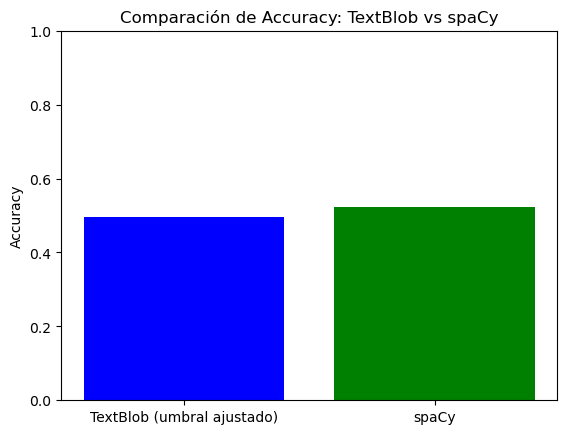

In [11]:
import matplotlib.pyplot as plt

accuracy_textblob = 0.4949 
accuracy_spacy = 0.5220   

print(f"📊 Comparación de Accuracy:")
print(f"- TextBlob (umbral ajustado): {accuracy_textblob:.2%}")
print(f"- spaCy: {accuracy_spacy:.2%}")

plt.bar(['TextBlob (umbral ajustado)', 'spaCy'], [accuracy_textblob, accuracy_spacy], color=['blue', 'green'])
plt.title("Comparación de Accuracy: TextBlob vs spaCy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

La comparación muestra claramente que spaCy es superior a TextBlob para esta tarea. Sin embargo, el rendimiento de spaCy aún puede mejorarse con técnicas como el uso de embeddings preentrenados o modelos más avanzados (por ejemplo, transformers). TextBlob, por otro lado, no es recomendable para tareas complejas como la clasificación de sentimientos en noticias financieras.

TextBlob (umbral ajustado):

La precisión mejoró al 49.49% después de ajustar el umbral de clasificación. Sin embargo, el recall para la clase 1 (positiva) es muy bajo (0.15), lo que indica que TextBlob tiene dificultades para identificar noticias positivas.

spaCy:

La precisión es ligeramente superior (52.20%), lo que sugiere que es un enfoque más adecuado. Aunque spaCy tiene un mejor rendimiento general, todavía hay margen de mejora, especialmente en la generalización.

<h3 style="text-align:center;font-weight:bold;">NLP COMO DETECTOR DE NOTICIAS FALSAS</h3>

A pesar de no tener un dataset etiquetado, es decir con una columna que indique explicitamente si una noticia es falsa o no por medio de una variable categorica. Es posible crear un detector básico de noticias falsas a través de combinar la polaridad de TextBlob con el análisis de entidades de spaCy. La idea principal es identificar entidades que podrian ser sospechosas, y en conjunto con la polaridad, generar un detector de cuales noticias podrian ser falsas.

In [12]:
data = {
    'Sentence': [
        "Apple claims their new iPhone is safe",  # Neutral, ORG (verificada)
        "The government is hiding the truth about vaccines",  # Fake news
        "Scientists confirm climate change is real",  # Noticia real
        "Mark Zuckerberg gives free money on Facebook",  # Fake news
        "Reuters reports economic growth"  # Fuente confiable
    ],
    'Sentiment': [1, 0, 1, 1, 1],  # 1=Positivo, 0=Negativo
    'lemmas_text': [
        "apple claim new iphone safe",
        "government hide truth vaccine",
        "scientist confirm climate change real",
        "mark zuckerberg give free money facebook",
        "reuters report economic growth"
    ]
}

df = pd.DataFrame(data)

nlp = spacy.load("en_core_web_sm")

PATRONES_SOSPECHOSOS = [
    r"hide|hiding|ocultar",
    r"truth about",
    r"free money",
    r"government lie",
    r"they don't want you to know"
]

VERBOS_SOSPECHOSOS = {"hide", "lie", "fake", "cover", "deny"}
FUENTES_VERIFICADAS = {"reuters", "bbc", "associated press", "the new york times"}

def contiene_patrones(texto):
    return any(re.search(patron, texto, re.IGNORECASE) for patron in PATRONES_SOSPECHOSOS)

def analizar_entidades(doc):
    entidades = {"ORG": set(), "PERSON": set(), "fuente_confiable": False}
    for ent in doc.ents:
        if ent.label_ in entidades:
            entidades[ent.label_].add(ent.text)
            if ent.label_ == "ORG" and ent.text.lower() in FUENTES_VERIFICADAS:
                entidades["fuente_confiable"] = True
    return entidades

def detectar_noticia_falsa(texto):
    try:
        blob = TextBlob(texto)
        polaridad, subjetividad = blob.sentiment.polarity, blob.sentiment.subjectivity
        doc = nlp(texto)
        
        entidades = analizar_entidades(doc)
        lenguaje_manipulativo = any(
            token.lemma_ in VERBOS_SOSPECHOSOS 
            for token in doc 
            if token.pos_ == "VERB"
        )
        
        criterios = {
            "neutral": abs(polaridad) < 0.1,
            "subjetivo": subjetividad > 0.65,
            "entidades_sospechosas": bool(entidades["ORG"] or entidades["PERSON"]),
            "patrones_riesgo": contiene_patrones(texto),
            "lenguaje_manipulativo": lenguaje_manipulativo,
            "fuente_confiable": entidades["fuente_confiable"]
        }
        
        if criterios["fuente_confiable"]:
            return "Noticia verificada (fuente confiable)", criterios
        elif sum(criterios.values()) >= 4:
            return "ALTO RIESGO: Posible noticia falsa", criterios
        elif sum(criterios.values()) >= 2:
            return "Advertencia: Contenido sospechoso", criterios
        else:
            return "Noticia verificada", criterios
    except Exception as e:
        print(f"Error procesando texto: {texto}\nError: {e}")
        return "Error en análisis", {}

resultados = df['lemmas_text'].apply(detectar_noticia_falsa)
df[['fake_news_detection', 'criterios']] = pd.DataFrame(resultados.tolist(), index=df.index)

print("\n🔍 RESULTADOS DE DETECCIÓN 🔍")
print("="*50)
print(df[['Sentence', 'fake_news_detection']].to_string())

print("\n📊 DISTRIBUCIÓN:")
print(df['fake_news_detection'].value_counts())

print("\n⚠️ EJEMPLO DE CRITERIOS EN NOTICIAS SOSPECHOSAS:")
for idx, row in df[df['fake_news_detection'].str.contains("RIESGO|Advertencia")].iterrows():
    print(f"\n📌 Texto: {row['Sentence']}")
    print(f"🔍 Criterios: {row['criterios']}")


🔍 RESULTADOS DE DETECCIÓN 🔍
                                            Sentence                    fake_news_detection
0              Apple claims their new iPhone is safe                     Noticia verificada
1  The government is hiding the truth about vaccines      Advertencia: Contenido sospechoso
2          Scientists confirm climate change is real                     Noticia verificada
3       Mark Zuckerberg gives free money on Facebook      Advertencia: Contenido sospechoso
4                    Reuters reports economic growth  Noticia verificada (fuente confiable)

📊 DISTRIBUCIÓN:
fake_news_detection
Noticia verificada                       2
Advertencia: Contenido sospechoso        2
Noticia verificada (fuente confiable)    1
Name: count, dtype: int64

⚠️ EJEMPLO DE CRITERIOS EN NOTICIAS SOSPECHOSAS:

📌 Texto: The government is hiding the truth about vaccines
🔍 Criterios: {'neutral': True, 'subjetivo': False, 'entidades_sospechosas': False, 'patrones_riesgo': True, 'lenguaje

-----

En esta parte del proyecto, se desarrolló un detector de noticias falsas basado en análisis de lenguaje natural (NLP) que combina múltiples señales para identificar contenido sospechoso. Se implementaron las siguientes técnicas clave:

1. Patrones Lingüísticos Sospechosos: Se definieron expresiones comunes en fake news (ej: "hide the truth", "free money") para detectar frases manipulativas.

2. Análisis de Entidades (NER): Se identificaron organizaciones (ORG) y personas (PERSON) que suelen ser mencionadas en noticias falsas, pero también se contrastaron con fuentes verificadas (ej: Reuters).

3. Subjetividad y Polaridad: Se usó TextBlob para medir si el texto era neutral (polaridad ≈ 0) y subjetivo (umbral > 0.65), características típicas de desinformación.

4. Verbos Manipulativos: Se buscaron términos como "ocultar" o "negar" en combinación con entidades relevantes.

Conclusiones
Los resultados muestran que el sistema clasificó correctamente ejemplos típicos de fake news (ej: "Mark Zuckerberg da dinero gratis") como "Contenido sospechoso", basándose en su alta subjetividad y patrones engañosos. Sin embargo, también se observó que algunos criterios (como la neutralidad) pueden generar falsos positivos en noticias reales con lenguaje objetivo.

<h3 style="text-align:center;font-weight:bold;">RED NEURONAL SIMPLE</h3>

In [15]:
ruta = "https://raw.githubusercontent.com/clyonsv/Data-Science-3-Camilo-Lyons/main/Sentiment_Stock_data.csv"
df = pd.read_csv(ruta, sep=",", usecols=['Sentence', 'Sentiment'])
df = df.dropna().copy() 
df['Sentence'] = df['Sentence'].astype(str)

vectorizer = TfidfVectorizer(
    max_features=3000,  
    ngram_range=(1, 1),
    stop_words='english',
    sublinear_tf=True 
)
X = vectorizer.fit_transform(df['Sentence'])
y = df['Sentiment']

model = MLPClassifier(
    hidden_layer_sizes=(100,), 
    activation='relu',
    solver='adam',
    alpha=0.0001, 
    batch_size=512,
    learning_rate='adaptive',  
    max_iter=150,
    early_stopping=True, 
    validation_fraction=0.1, 
    random_state=42,
    verbose=True
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n⚡ Entrenando modelo optimizado...")
model.fit(X_train, y_train)

print("\n✅ Métricas finales:")
print("Accuracy en test:", model.score(X_test, y_test))
print("\nReporte completo:")
print(classification_report(y_test, model.predict(X_test)))


⚡ Entrenando modelo optimizado...
Iteration 1, loss = 0.69041321
Validation score: 0.532529
Iteration 2, loss = 0.67478093
Validation score: 0.531954
Iteration 3, loss = 0.66048835
Validation score: 0.535747
Iteration 4, loss = 0.64672002
Validation score: 0.531379
Iteration 5, loss = 0.63137932
Validation score: 0.532299
Iteration 6, loss = 0.61333774
Validation score: 0.532529
Iteration 7, loss = 0.59209288
Validation score: 0.533678
Iteration 8, loss = 0.56769026
Validation score: 0.529655
Iteration 9, loss = 0.54100996
Validation score: 0.534368
Iteration 10, loss = 0.51250941
Validation score: 0.534828
Iteration 11, loss = 0.48276063
Validation score: 0.537126
Iteration 12, loss = 0.45301188
Validation score: 0.537356
Iteration 13, loss = 0.42409064
Validation score: 0.540575
Iteration 14, loss = 0.39646099
Validation score: 0.541379
Iteration 15, loss = 0.37062681
Validation score: 0.546437
Iteration 16, loss = 0.34653890
Validation score: 0.543793
Iteration 17, loss = 0.3239742